# Testing Dimensionality Reduction Methods

First: reducing dimensionality of handwritten images

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784", as_frame=False)
Xtrain, ytrain = mnist.data[:60000], mnist.target[:60000]
Xtest, ytest = mnist.data[60000:], mnist.target[60000:]

In [2]:
import matplotlib.pyplot as plt
def plotDigit(data):
    plt.imshow(data.reshape(28,28), cmap="binary")
    plt.axis("off")

In [3]:
from sklearn.ensemble import RandomForestClassifier

rfModel = RandomForestClassifier(n_estimators=200, max_depth=20, n_jobs=-1)
rfModel.fit(Xtrain, ytrain)

RandomForestClassifier(max_depth=20, n_estimators=200, n_jobs=-1)

Score: 0.9696


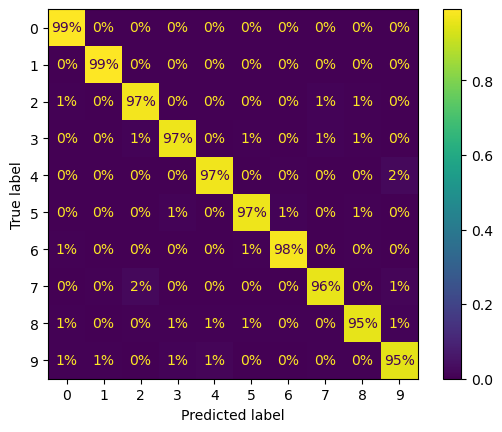

In [4]:
from sklearn.metrics import ConfusionMatrixDisplay
preds = rfModel.predict(Xtest)
print("Score:",rfModel.score(Xtest, ytest))
ConfusionMatrixDisplay.from_predictions(ytest, preds, normalize="true", values_format=".0%")

No PCA: Random Forest takes around 6-7 seconds, 97% accuracy, worst digit is 95-96%

In [5]:
from sklearn.decomposition import PCA

pca = PCA(n_components=.95)
Xreduced = pca.fit_transform(Xtrain)
Xreduced

array([[ 123.93258866, -312.67426202,  -24.51405176, ...,   55.01899792,
         -20.08327427,   39.58995229],
       [1011.71837587, -294.85703827,  596.33956104, ...,    7.24129874,
         -12.45780869,  -12.7432306 ],
       [ -51.84960805,  392.17315286, -188.50974943, ...,  -54.19582221,
          48.47979747,  -73.27826256],
       ...,
       [-178.0534496 ,  160.07821109, -257.61308227, ...,   55.54485537,
          87.99883556,   -5.78979735],
       [ 130.60607208,   -5.59193642,  513.85867395, ...,   23.30835402,
           5.06237836,  -65.26525587],
       [-173.43595244,  -24.71880226,  556.01889393, ...,   52.4956069 ,
          12.63192292,  -45.74001227]])

In [6]:
rfModel = RandomForestClassifier(n_estimators=200, max_depth=20, n_jobs=-1)
rfModel.fit(Xreduced, ytrain)

RandomForestClassifier(max_depth=20, n_estimators=200, n_jobs=-1)

Score: 0.9507


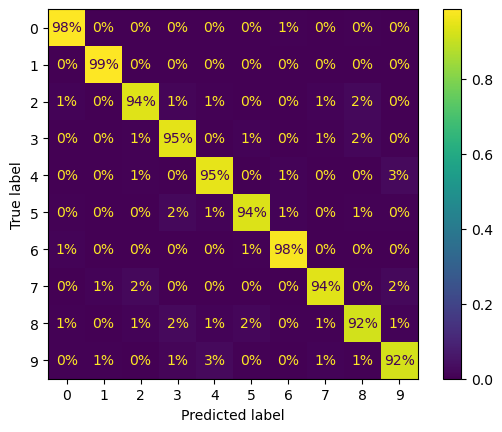

In [7]:
test2 = pca.transform(Xtest)
preds = rfModel.predict(test2)
print("Score:",rfModel.score(test2, ytest))
ConfusionMatrixDisplay.from_predictions(ytest, preds, normalize="true", values_format=".0%")

Using PCA here reduced accuracy 2%, made our worst digit 91% accurate, and made training 4x slower.

Why this happened:
-input isnt dense anymore
-random forests dont go well with pca reduced data

Score: 0.8761


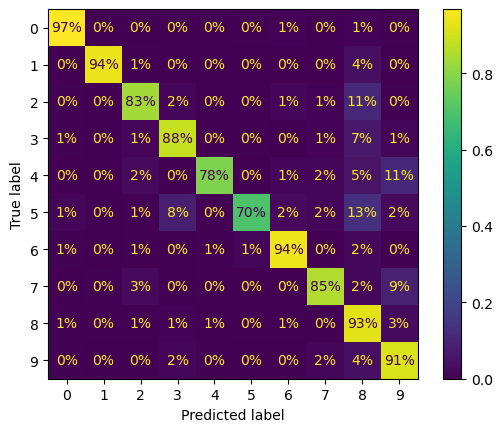

In [8]:
# Trying w/ SGD Classifier
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(n_jobs=-1)
sgd.fit(Xtrain, ytrain)
preds = sgd.predict(Xtest)
print("Score:",sgd.score(Xtest, ytest))
ConfusionMatrixDisplay.from_predictions(ytest, preds, normalize="true", values_format=".0%")

Score: 0.8925


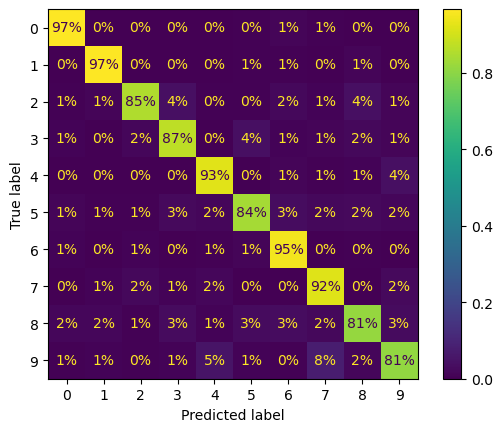

In [9]:
# Trying with SGD and PCA-reduced X
sgd = SGDClassifier(n_jobs=-1)
sgd.fit(Xreduced, ytrain)
preds = sgd.predict(pca.transform(Xtest))
print("Score:",sgd.score(pca.transform(Xtest), ytest))
ConfusionMatrixDisplay.from_predictions(ytest, preds, normalize="true", values_format=".0%")

For SGD Classification, PCA massively accelerates training and helps accuracy (marginally).

$$
\begin{array}{|l|l|l|}
\hline
\textbf{Classifier} & \textbf{Benefit Level} & \textbf{Why} \\
\hline
\text{k-Nearest Neighbors} & \text{High} & \text{Curse of dimensionality; faster distance calc} \\
\hline
\text{Support Vector Machines} & \text{High} & \text{Reduced training complexity, better kernels} \\
\hline
\text{Logistic Regression} & \text{Medium} & \text{Faster training, fewer parameters} \\
\hline
\text{Linear Discriminant Analysis} & \text{Medium} & \text{Speed improvement, cleaner separation} \\
\hline
\text{Naive Bayes} & \text{Medium} & \text{PCA creates uncorrelated features} \\
\hline
\text{Neural Networks} & \text{Medium} & \text{Faster training, but learns own features} \\
\hline
\text{Random Forests} & \text{Low} & \text{Handles high dimensions well natively} \\
\hline
\text{Decision Trees} & \text{Low} & \text{Built-in feature selection} \\
\hline
\text{Gradient Boosting} & \text{Low} & \text{Robust to dimensionality} \\
\hline
\end{array}
$$

## Compressing 784-dimension image data into 2 dimensions

In [10]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, n_jobs=-1)
tsneReduced = tsne.fit_transform(Xtrain[:5000])
tsneReduced

array([[ 17.097141,   9.229305],
       [ 60.055847,  24.304974],
       [ 14.299513, -53.212894],
       ...,
       [-29.963684,  47.90794 ],
       [-35.99484 ,   7.573737],
       [-33.8817  ,  44.292606]], dtype=float32)

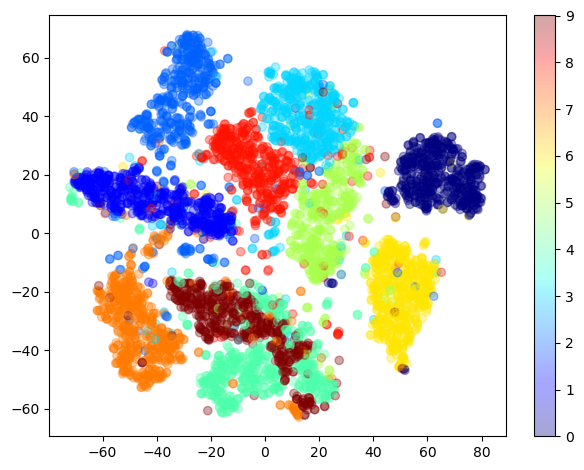

In [28]:
import matplotlib.pyplot as plt
import numpy as np

plt.scatter(tsneReduced[:,0], tsneReduced[:,1], alpha=.35, c=ytrain[:5000].astype("int"), cmap="jet")
# handles = []
# for label in np.unique(ytrain[:5000].astype("int")):
#     handles.append(plt.Line2D([0], [0], marker='o', color='w', 
#                               markerfacecolor=plt.cm.tab10(label/10), 
#                               markersize=8, label=f'{label}'))
# plt.legend(handles=handles, loc='upper right', bbox_to_anchor=(1.15, 1))
plt.colorbar()
plt.tight_layout()
plt.show()

The Y and X axes are basically meaningless for humans. Note how similar 4's and 9's are, it makes sense why they are the most confused by models. Interestingly, you can see 3's all over the place, like the clump between 1 and 9. It's hard to imagine a human drawing a 3 that could be confused for both a 1 and a 9.

In [ ]:
# This code directly taken from https://colab.research.google.com/github/ageron/handson-mlp/blob/main/07_dimensionality_reduction.ipynb#scrollTo=koiUl6sFjdZv 

from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

def plot_digits(X, y, min_distance=0.04, images=None, figsize=(13, 10)):
    # Let's scale the input features so that they range from 0 to 1
    X_normalized = MinMaxScaler().fit_transform(X)
    # Now we create the list of coordinates of the digits plotted so far.
    # We pretend that one is already plotted far away at the start, to
    # avoid `if` statements in the loop below
    neighbors = np.array([[10., 10.]])
    # The rest should be self-explanatory
    plt.figure(figsize=figsize)
    cmap = plt.cm.jet
    digits = np.unique(y)
    for digit in digits:
        plt.scatter(X_normalized[y == digit, 0], X_normalized[y == digit, 1],
                    c=[cmap(float(digit) / 9)], alpha=0.5)
    plt.axis("off")
    ax = plt.gca()  # get current axes
    for index, image_coord in enumerate(X_normalized):
        closest_distance = np.linalg.norm(neighbors - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is None:
                plt.text(image_coord[0], image_coord[1], str(int(y[index])),
                         color=cmap(float(y[index]) / 9),
                         fontdict={"weight": "bold", "size": 16})
            else:
                image = images[index].reshape(28, 28)
                imagebox = AnnotationBbox(OffsetImage(image, cmap="binary"),
                                          image_coord)
                ax.add_artist(imagebox)

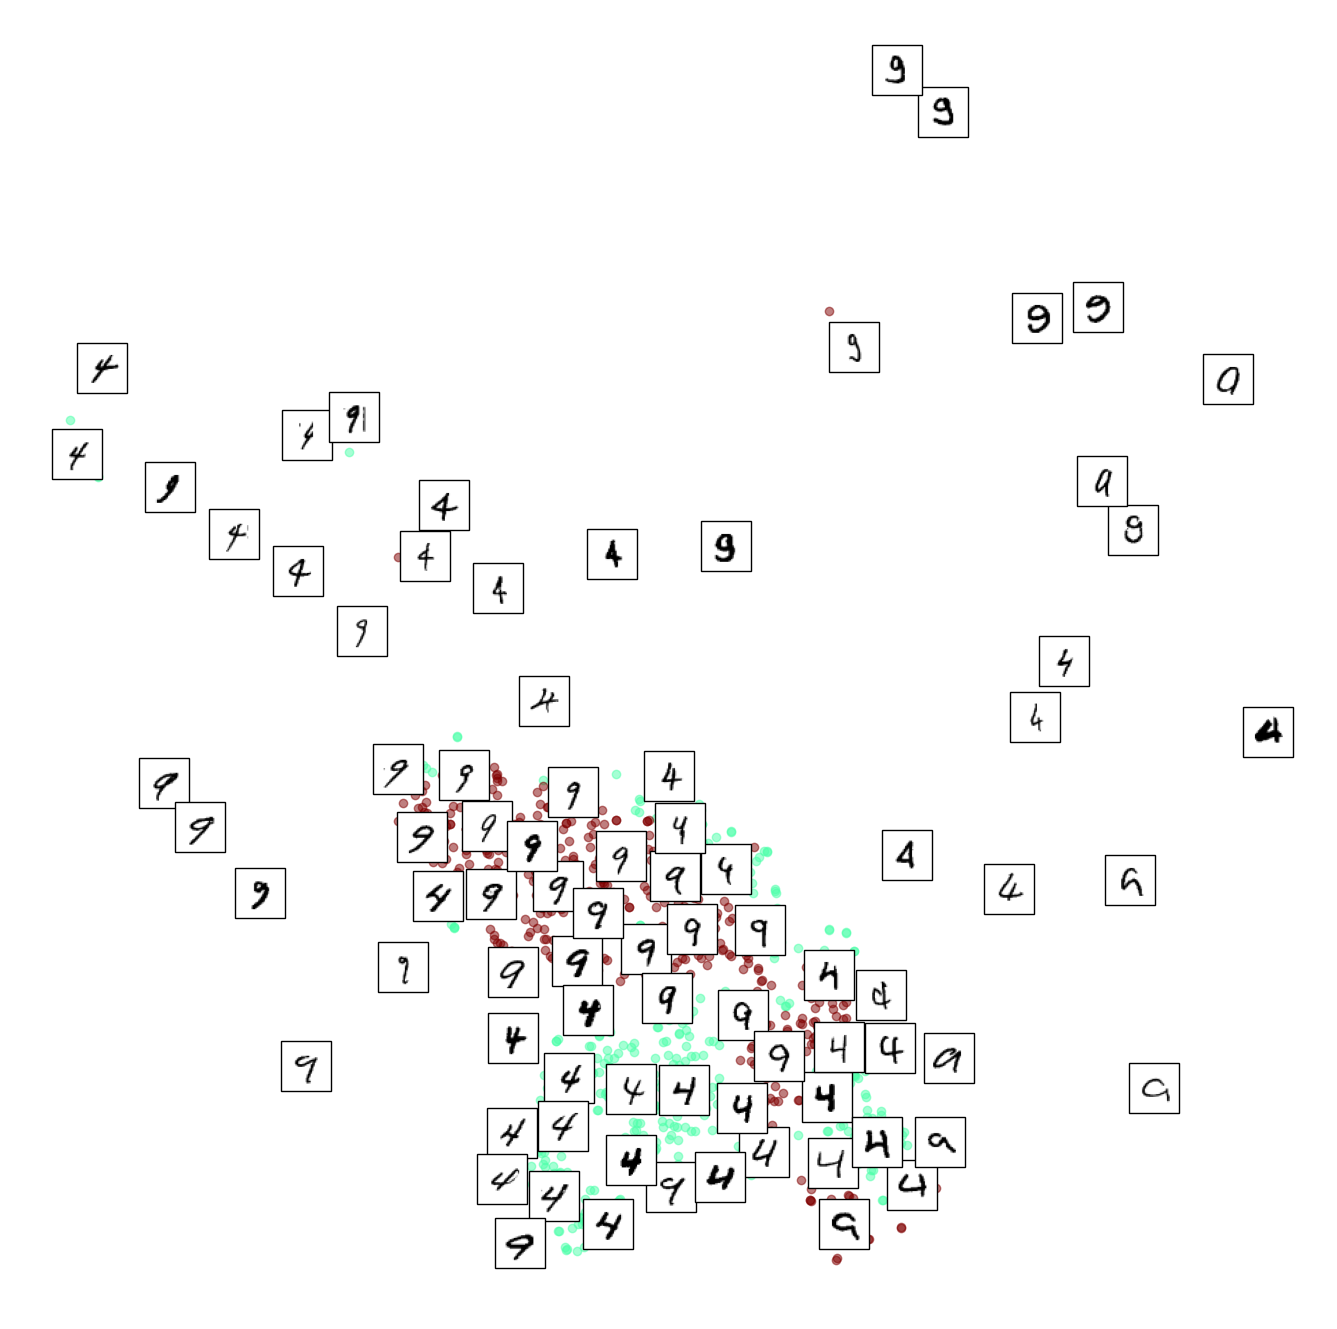

In [40]:
# Compare two digits with this cell

digit1 = 9
digit2= 4

index = (ytrain.astype("int")[:5000] == digit1) | (ytrain.astype("int")[:5000] == digit2)
xsmall = tsneReduced[:5000][index]
ysmall = ytrain[:5000][index]
imgs = Xtrain[:5000][index]

plot_digits(xsmall, ysmall, images=imgs, figsize=(17,17))